Importing the Dependencies

In [43]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [44]:
def read_csv(file_path):
    """Read data from a CSV file."""
    return pd.read_csv(file_path)

def dataset_info_statistics(data):
    """Display dataset information and basic statistics."""
    print("Dataset Information:")
    print(data.info())
    print("\nBasic Statistics:")
    print(data.describe())
    print("\n")

def check_null(data):
    """Check for null values in the dataset."""
    null_counts = data.isnull().sum()
    print("Null Values:")
    print(null_counts[null_counts > 0])

def check_duplicates(data):
    """Check and display duplicate rows in the dataset."""
    duplicate_count = data.duplicated().sum()
    print(f"Number of duplicate rows: {duplicate_count}")

def plot_graph(data):
    """Plot histograms and countplots for numerical and categorical data."""
    numerical_columns = data.select_dtypes(include=np.number).columns
    for column in numerical_columns:
        plt.figure(figsize=(5, 3))
        sns.histplot(data[column], kde=True)
        plt.title(f"Histogram for {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()

    categorical_columns = data.select_dtypes(include='object').columns
    for column in categorical_columns:
        plt.figure(figsize=(5, 3))
        sns.countplot(x=data[column], order=data[column].value_counts().index)
        plt.title(f'Countplot for {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

def separate_features_target(data, target_column):
    """Separate features and target variable."""
    X = data.drop(columns=[target_column])
    y = data[target_column]
    return X, y

def perform_train_test_split(X, y, test_size=0.20, random_state=42):
    """Perform train-test split."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance using multiple metrics."""
    y_pred = model.predict(X_test)
    print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

def feature_importance(model, X):
    """Display feature importance for tree-based models."""
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        print(feature_importance_df)
    else:
        print("Feature importance not available for this model.")

def tune_hyperparameters(model, param_grid, X_train, y_train):
    """Perform hyperparameter tuning using GridSearchCV."""
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    print(f"Best Parameters: {grid_search.best_params_}")
    return grid_search.best_estimator_

Data Collection & Processing

In [45]:
# loading the data from csv file to a Pandas DataFrame
data = pd.read_csv('/content/data.csv')

In [46]:
# print the first 5 rows of the dataframe
data.head()

User_ID  Gender  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  \
0  14733363    male   68     190      94        29         105       40.8   
1  14861698  female   20     166      60        14          94       40.3   
2  11179863    male   69     179      79         5          88       38.7   
3  16180408  female   34     179      71        13         100       40.5   
4  17771927  female   27     154      58        10          81       39.8   

   Calories  
0       231  
1        66  
2        26  
3        71  
4        35

In [47]:
# checking the number of rows and columns
data.shape

(15000, 9)

In [48]:
# getting some informations about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  int64  
 4   Weight      15000 non-null  int64  
 5   Duration    15000 non-null  int64  
 6   Heart_Rate  15000 non-null  int64  
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 1.0+ MB


In [49]:
# checking for missing values
data.isnull().sum()

User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [50]:
# Calculate the mean only for numerical columns
numerical_data = data.select_dtypes(include=np.number)
data.fillna(numerical_data.mean(), inplace=True)

In [51]:
# get some statistical measures about the data
data.describe()

User_ID           Age        Height        Weight      Duration  \
count  1.500000e+04  15000.000000  15000.000000  15000.000000  15000.000000   
mean   1.497736e+07     42.789800    174.465133     74.966867     15.530600   
std    2.872851e+06     16.980264     14.258114     15.035657      8.319203   
min    1.000116e+07     20.000000    123.000000     36.000000      1.000000   
25%    1.247419e+07     28.000000    164.000000     63.000000      8.000000   
50%    1.499728e+07     39.000000    175.000000     74.000000     16.000000   
75%    1.744928e+07     56.000000    185.000000     87.000000     23.000000   
max    1.999965e+07     79.000000    222.000000    132.000000     30.000000   

         Heart_Rate     Body_Temp      Calories  
count  15000.000000  15000.000000  15000.000000  
mean      95.518533     40.025453     89.539533  
std        9.583328      0.779230     62.456978  
min       67.000000     37.100000      1.000000  
25%       88.000000     39.600000     35.000000  
50%       96.000000     40.200000     79.000000  
75%      103.000000     40.600000    138.000000  
max      128.000000     41.500000    314.000000

In [52]:
data.columns

Index(['User_ID', 'Gender', 'Age', 'Height', 'Weight', 'Duration',
       'Heart_Rate', 'Body_Temp', 'Calories'],
      dtype='object')

In [53]:
X,y = separate_features_target(data,'Calories') # Changed 'seperate' to 'separate'

In [54]:
X = X.drop(columns=['User_ID'])


In [55]:
X_train,X_test,y_train,y_test = perform_train_test_split(X, y, test_size=0.20, random_state=42)

Data Visualization

In [56]:
sns.set()

<Axes: xlabel='count', ylabel='Gender'>

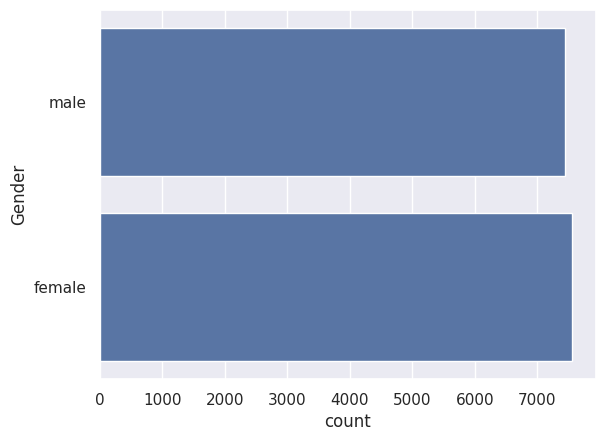

In [57]:
# plotting the gender column in count plot
sns.countplot(data['Gender'])

<Axes: xlabel='Age', ylabel='Density'>

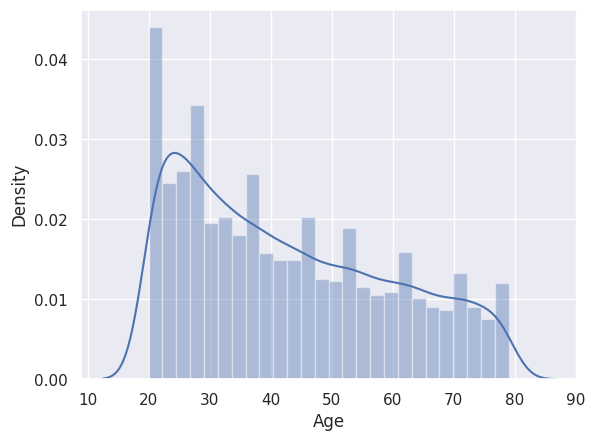

In [58]:
# finding the distribution of "Age" column
sns.distplot(data['Age'])

<Axes: xlabel='Height', ylabel='Density'>

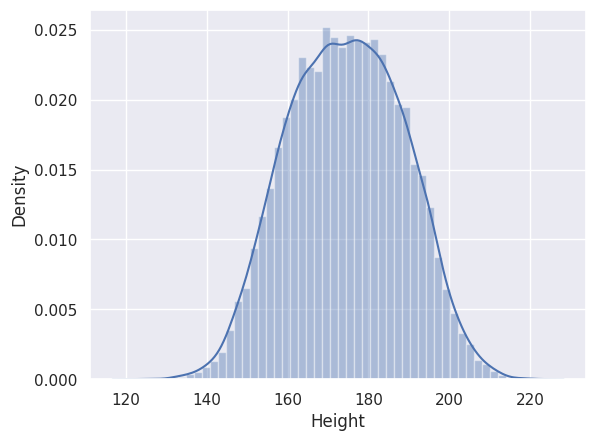

In [59]:
# finding the distribution of "Height" column
sns.distplot(data['Height'])

<Axes: xlabel='Weight', ylabel='Density'>

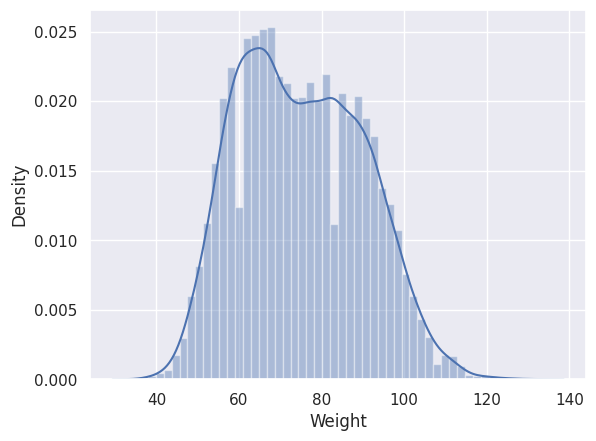

In [60]:
# finding the distribution of "Weight" column
sns.distplot(data['Weight'])

Column Transformer and Pipeline


In [61]:
preprocessor = ColumnTransformer(transformers=[
    ('ordinal',OrdinalEncoder(),['Gender']),
    ('num',StandardScaler(),['Age',
                            'Height',
                            'Weight',
                            'Duration',
                            'Heart_Rate',
                            'Body_Temp']),
],remainder='passthrough')

In [62]:
pipeline = Pipeline([("preprocessor",preprocessor),
                     ("model",LinearRegression())
                    ])

In [63]:
from sklearn import set_config
set_config(display='diagram')

In [64]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal', OrdinalEncoder(),
                                                  ['Gender']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'Height', 'Weight',
                                                   'Duration', 'Heart_Rate',
                                                   'Body_Temp'])])),
                ('model', LinearRegression())])

In [65]:
pipeline.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal', OrdinalEncoder(),
                                                  ['Gender']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'Height', 'Weight',
                                                   'Duration', 'Heart_Rate',
                                                   'Body_Temp'])])),
                ('model', LinearRegression())])

In [66]:
y_pred = pipeline.predict(X_test)

In [67]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.967338558066749

In [68]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [69]:
from sklearn.model_selection import cross_val_score
cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring='r2')
cv_results.mean()

0.9671402283675841

In [70]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test,y_pred)

8.453874325050732

In [71]:
def model_scorer(model_name,model):

    output=[]


    output.append(model_name)

    pipeline = Pipeline([
    ('preprocessor',preprocessor),
    ('model',model)])

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

    pipeline.fit(X_train,y_train)

    y_pred = pipeline.predict(X_test)

    output.append(r2_score(y_test,y_pred))
    output.append(mean_absolute_error(y_test,y_pred))

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_val_score(pipeline, X, y, cv=kfold, scoring='r2')
    output.append(cv_results.mean())

    return output

In [72]:
model_dict={
    'log':LinearRegression(),
    'RF':RandomForestRegressor(),
    'XGBR':XGBRegressor(),
}

In [73]:
model_output=[]
for model_name,model in model_dict.items():
   model_output.append(model_scorer(model_name,model))

In [74]:
model_output

[['log', 0.9672937151257295, 8.441513553849704, 0.9671402283675841],
 ['RF', 0.9982628747778369, 1.6950766666666666, 0.9979498602473276],
 ['XGBR', 0.9988678693771362, 1.498119831085205, 0.9988510847091675]]

In [75]:
preprocessor = ColumnTransformer(transformers=[
    ('ordinal',OrdinalEncoder(),['Gender']),
    ('num',StandardScaler(),['Age',
                            'Height',
                            'Weight',
                            'Duration',
                            'Heart_Rate',
                            'Body_Temp']),

],remainder='passthrough')


In [76]:
pipeline = Pipeline([
    ('preprocessor',preprocessor),
    ('model',XGBRegressor())

])

In [77]:
pipeline.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal', OrdinalEncoder(),
                                                  ['Gender']),
                                                 ('num', StandardScaler(),
                                                  ['Age', 'Height', 'Weight',
                                                   'Duration', 'Heart_Rate',
                                                   'Body_Temp'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [78]:
sample = pd.DataFrame({
   'Gender':'male',
    'Age':68,
    'Height':190.0,
    'Weight':94.0,
    'Duration':29.0,
    'Heart_Rate':105.0,
    'Body_Temp':40.8,
},index=[0])

In [79]:
pipeline.predict(sample)

array([231.0721], dtype=float32)

Save The Model


In [80]:
import pickle
with open('pipeline.pkl','wb') as f:
    pickle.dump(pipeline,f)
with open('pipeline.pkl','rb') as f:
    pipeline_saved = pickle.load(f)
result = pipeline_saved.predict(sample)
result

array([231.0721], dtype=float32)

GUI

In [81]:
import pickle
import pandas as pd

# Load the model
with open('pipeline.pkl', 'rb') as f:
    pipeline = pickle.load(f)

# Get user inputs
gender = input("Enter Gender (male/female): ")
age = float(input("Enter Your Age: "))
height = float(input("Enter Your Height: "))
weight = float(input("Enter Your Weight: "))
duration = float(input("Enter Duration: "))
heart_rate = float(input("Enter Heart Rate: "))
body_temp = float(input("Enter Body Temp: "))

# Create a DataFrame for prediction
sample = pd.DataFrame({
    'Gender': [gender],
    'Age': [age],
    'Height': [height],
    'Weight': [weight],
    'Duration': [duration],
    'Heart_Rate': [heart_rate],
    'Body_Temp': [body_temp],
}, index=[0])

# Make the prediction
result = pipeline.predict(sample)

# Print the result
print("Amount of Calories Burnt:", result[0])

Enter Gender (male/female): female
Enter Your Age: 20
Enter Your Height: 170
Enter Your Weight: 60
Enter Duration: 45
Enter Heart Rate: 100
Enter Body Temp: 90
Amount of Calories Burnt: 160.11273
